In [2]:
# import appropriate libraries
import pandas as pd
from google.colab import files
import io
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc

In [3]:
# import data
uploaded = files.upload()

Saving all_subreddits_mpx_data_liwc_features.csv to all_subreddits_mpx_data_liwc_features.csv


In [41]:
len(psych_data)

8605

In [4]:
# convert data into a dataframe
df = pd.read_csv(io.StringIO(uploaded['all_subreddits_mpx_data_liwc_features.csv'].decode('utf-8')), sep = ',', header = "infer", index_col = 0 )

# we only want to look at the LIWC terms
# We will get rid of colums 0-11 in order to focus on LIWC terms
df.drop(['body', 'subreddit', 'created_utc', 'retrieved_utc', 'permalink',
       'link_id', 'parent_id', 'converted_createdutc', 'thread_title',
       'contains_monkeypox_term', 'contains_epoxy_term'], axis=1, inplace=True)
df.head()

,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
author,,,,,,,,,,,,,,,,,,,,,
clueless_claremont_,30,25.89,25.24,43.37,25.77,10.00,3.33,90.00,60.00,20.00,...,0.00,3.33,0.0,0.0,0.00,0.00,0.0,0.00,0.00,6.67
Lizardd06,38,71.12,85.38,4.05,25.77,19.00,23.68,71.05,36.84,10.53,...,5.26,0.00,0.0,0.0,0.00,5.26,0.0,2.63,15.79,18.42
AnseaCirin,22,57.84,3.48,99.00,94.75,11.00,13.64,95.45,54.55,13.64,...,9.09,0.00,0.0,0.0,0.00,0.00,0.0,9.09,0.00,0.00
Pirascule,45,84.62,67.16,82.75,1.00,11.25,15.56,93.33,48.89,13.33,...,2.22,0.00,0.0,0.0,2.22,0.00,0.0,6.67,0.00,0.00
JLH4AC,62,94.63,96.18,5.30,25.77,62.00,17.74,87.10,59.68,6.45,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00


In [5]:
# For the cluster analysis, we only want to look at the LIWC terms that are related to psychological processes
# We will get rid of colums if they are not related to pyschological processes and perform cluster analysis
psych_data = df.drop(['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic',
                      'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
                      'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
                      'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'AllPunc', 
                      'Period', 'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 
                      'Apostro', 'Parenth', 'OtherP'], axis=1 )
psych_data.head()

,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
author,,,,,,,,,,,,,,,,,,,,,
clueless_claremont_,0.00,0.00,0.00,0.0,0.00,0.0,6.67,0.0,0.00,0.0,...,3.33,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0
Lizardd06,0.00,0.00,0.00,0.0,0.00,0.0,15.79,0.0,5.26,0.0,...,5.26,0.0,2.63,0.0,2.63,0.00,2.63,0.0,0.0,0.0
AnseaCirin,9.09,4.55,0.00,0.0,0.00,0.0,9.09,0.0,0.00,0.0,...,0.00,0.0,4.55,0.0,0.00,0.00,0.00,0.0,0.0,0.0
Pirascule,4.44,0.00,4.44,0.0,2.22,0.0,13.33,0.0,0.00,0.0,...,2.22,0.0,2.22,0.0,2.22,2.22,0.00,0.0,0.0,0.0
JLH4AC,0.00,0.00,0.00,0.0,0.00,0.0,17.74,0.0,0.00,0.0,...,0.00,0.0,3.23,0.0,0.00,0.00,0.00,0.0,0.0,0.0


In [6]:
# Create a function that will run the kmeans algorithm with the desired specifications
def kmeans_cluster( data_df, max_num_clusters ):

  # Create list that will store all silhouette coefficients
  sil_coef = []

  # Run kmeans and obtain the silhouette coefficient for all clusters from 2 to the max_num_clusters
  for num_clusters in range ( 2, max_num_clusters + 1 ):
    cluster = KMeans( n_clusters = num_clusters )
    cluster_labels = cluster.fit_predict ( data_df )
    sil_value = silhouette_score( data_df, cluster_labels )
    sil_coef.append( sil_value )
  
  return sil_coef

In [7]:
# We want to obtain the efficiency (running time) of each analysis
# The start and stop variable will be used to obtain the efficiency
start = timeit.default_timer()

# Run k-means twice and take the average of the silhouette coefficients
sil_coef_1 = kmeans_cluster( psych_data, 10 )
sil_coef_2 = kmeans_cluster( psych_data, 10 )
sil_coef_avg = []

# Obtain the average of the silhouette coefficients
for i in range( len( sil_coef_1 )):
  sil_coef_avg.append(( sil_coef_1[ i ] + sil_coef_2[ i ] ) / 2)

# Print the average silhouette coefficients
for i in range( len( sil_coef_avg )):
  print( "For n_clusters =", i + 2, "the average silhouette_score is:", sil_coef_avg[ i ] ) 

# Find the highest silhouette coefficient to find the best k 
# Find the index of the highest silhouette coefficient
max_sil_coef_index = sil_coef_avg.index( max( sil_coef_avg ))

# k = max_sil_coef_index + 2 because number of clusters starts at k=2
best_k = max_sil_coef_index + 2
print( "The best k is", best_k, "since it has the highest silhouette score." )

stop = timeit.default_timer()
print('Time (in seconds) to run analysis for best number of clusters by looking at silhouette_score of kmeans clusters: ', stop - start)

For n_clusters = 2 the average silhouette_score is: 0.613153392063325
For n_clusters = 3 the average silhouette_score is: 0.07404913995344348
For n_clusters = 4 the average silhouette_score is: 0.06796106597005629
For n_clusters = 5 the average silhouette_score is: 0.06908170645423017
For n_clusters = 6 the average silhouette_score is: 0.06549230381834803
For n_clusters = 7 the average silhouette_score is: 0.0624896594467594
For n_clusters = 8 the average silhouette_score is: 0.04958455888693129
For n_clusters = 9 the average silhouette_score is: 0.04882953417134614
For n_clusters = 10 the average silhouette_score is: 0.05112252927901095
The best k is 2 since it has the highest silhouette score.
Time (in seconds) to run analysis for best number of clusters by looking at silhouette_score of kmeans clusters:  48.72540326199987


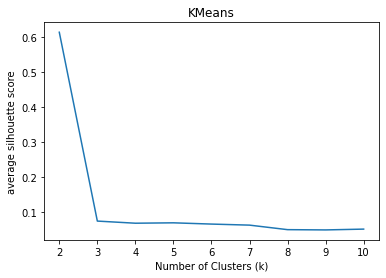

In [8]:
plt.plot( range( 2,11 ), sil_coef_avg )
plt.xlabel("Number of Clusters (k)")
plt.ylabel("average silhouette score")
plt.title("KMeans")
plt.show()

In [9]:
start = timeit.default_timer()

# Run kmeans cluster analysis
kmeans = KMeans( n_clusters = best_k ).fit( psych_data )
kmeans_labels = kmeans.fit_predict ( psych_data )

stop = timeit.default_timer()
kmeans_runtime = stop - start

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

start = timeit.default_timer()

# run agglomerative clustering analysis
aggclustering = AgglomerativeClustering( n_clusters = best_k )
agg_labels = aggclustering.fit_predict( psych_data )
agg_cent = NearestCentroid()
agg_cent.fit( psych_data, agg_labels )

stop = timeit.default_timer()
agg_runtime = stop - start

In [11]:
# Create a function that will run the agglomerative clustering algorithm
def agg_cluster( data_df, max_num_clusters ):

  # Create list that will store all silhouette coefficients
  sil_coef = []

  # Run kmeans and obtain the silhouette coefficient for all clusters from 2 to the max_num_clusters
  for num_clusters in range ( 2, max_num_clusters + 1 ):
    cluster = AgglomerativeClustering( n_clusters = num_clusters )
    agg_labels = cluster.fit_predict( data_df )
    sil_value = silhouette_score( data_df, agg_labels )
    sil_coef.append( sil_value )
  
  return sil_coef

In [12]:
start = timeit.default_timer()

# Trying to find the silhouette coefficients for k = [2,10]
sil_coef_agg = agg_cluster( psych_data, 10 )

print( "Calculating silhouette coefficients of agglomerative clustering for k = [2,10]" )
# Print the average silhouette coefficients
for i in range( len( sil_coef_agg )):
  print( "For n_clusters =", i + 2, "the average silhouette_score is:", sil_coef_agg[ i ] )

stop = timeit.default_timer()
print('Time (in seconds) to run analysis for best number of clusters by looking at silhouette_score of agglomerative clusters: ', stop - start)

Calculating silhouette coefficients of agglomerative clustering for k = [2,10]
For n_clusters = 2 the average silhouette_score is: 0.6921937930324793
For n_clusters = 3 the average silhouette_score is: 0.30312554493886545
For n_clusters = 4 the average silhouette_score is: 0.11294434628598782
For n_clusters = 5 the average silhouette_score is: 0.11435635421262436
For n_clusters = 6 the average silhouette_score is: 0.08498553776482959
For n_clusters = 7 the average silhouette_score is: 0.08856406477934348
For n_clusters = 8 the average silhouette_score is: 0.0013520406989378309
For n_clusters = 9 the average silhouette_score is: -0.002820916900021516
For n_clusters = 10 the average silhouette_score is: -0.015524997559349525
Time (in seconds) to run analysis for best number of clusters by looking at silhouette_score of agglomerative clusters:  48.039306729000145


In [13]:
from sklearn.mixture import GaussianMixture

start = timeit.default_timer()

# Run gaussian mixture modeling analysis
gmm = GaussianMixture( n_components = best_k ).fit( psych_data )
gmm_labels = gmm.predict( psych_data )

stop = timeit.default_timer()
gmm_runtime = stop - start

In [14]:
# Create a function that will run the agglomerative clustering algorithm
def gmm_clust( data_df, max_num_clusters ):

  # Create list that will store all silhouette coefficients
  sil_coef = []

  # Run gmm and obtain the silhouette coefficient for all clusters from 2 to the max_num_clusters
  for num_clusters in range ( 2, max_num_clusters + 1 ):
    gmm_cluster = GaussianMixture( n_components = num_clusters ).fit( data_df )
    gmm_labels = gmm_cluster.predict( data_df )
    sil_value = silhouette_score( data_df, gmm_labels )
    sil_coef.append( sil_value )
  
  return sil_coef

In [15]:
start = timeit.default_timer()

# Trying to find the silhouette coefficients for k = [2,10]
sil_coef_gmm = gmm_clust( psych_data, 10 )

print( "Calculating silhouette coefficients of Gaussian Mixture Modeling for k = [2,10]" )
# Print the average silhouette coefficients
for i in range( len( sil_coef_gmm ) ):
  print( "For n_clusters =", i + 2, "the average silhouette_score is:", sil_coef_gmm[ i ] )

stop = timeit.default_timer()
print('Time (in seconds) to run analysis for best number of clusters by looking at silhouette_score of gaussian mixture model clusters: ', stop - start)

Calculating silhouette coefficients of Gaussian Mixture Modeling for k = [2,10]
For n_clusters = 2 the average silhouette_score is: -0.035241335257408184
For n_clusters = 3 the average silhouette_score is: -0.09799559721110272
For n_clusters = 4 the average silhouette_score is: -0.10628433097238475
For n_clusters = 5 the average silhouette_score is: -0.17849456332390243
For n_clusters = 6 the average silhouette_score is: -0.2082791515406592
For n_clusters = 7 the average silhouette_score is: -0.19516529596554671
For n_clusters = 8 the average silhouette_score is: -0.17486627488283424
For n_clusters = 9 the average silhouette_score is: -0.21209837527304193
For n_clusters = 10 the average silhouette_score is: -0.20616932927878426
Time (in seconds) to run analysis for best number of clusters by looking at silhouette_score of gaussian mixture model clusters:  43.01192681200018


In [16]:
from sklearn.cluster import SpectralClustering

start = timeit.default_timer()

# Run spectral clustering analysis
spec_cluster = SpectralClustering( n_clusters = best_k, eigen_solver = 'lobpcg' ).fit( psych_data )

stop = timeit.default_timer()
spec_runtime = stop - start

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:371: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:372: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/pytho

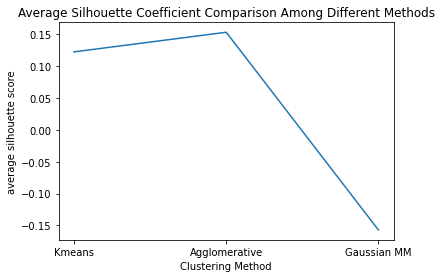

In [17]:
import statistics as stat

# sil_coef_avg = kmeans silhouette scores for k = [2,10]
# sil_coef_agg = agglomerative clustering silhouette scores for k = [2,10]
# sil_coef_gmm = gaussian mixture modeling silhouette scores for k = [2,10]
# sil_coef_spec = spectral clustering silhouette scores for k = [2,10]
  # excluded spectral clustering due to following error: 
  # "Graph is not fully connected, spectral embedding may not work as expected."

# Create the labels for each method
clust_meth = [ "Kmeans", "Agglomerative", "Gaussian MM" ]

# Calculate the average of the silhouette coefficients for each method
avg_sil_coef = [stat.mean(sil_coef_avg), stat.mean(sil_coef_agg), stat.mean(sil_coef_gmm)]

plt.plot( clust_meth, avg_sil_coef )
plt.xlabel("Clustering Method")
plt.ylabel("average silhouette score")
plt.title("Average Silhouette Coefficient Comparison Among Different Methods")
plt.show()

In [18]:
print('Time to run kmeans cluster analysis: ', kmeans_runtime ) 
print('Time to run agglomerative cluster analysis: ', agg_runtime ) 
print('Time to run gaussian mixture modeling analysis: ', gmm_runtime ) 
print('Time to run spectral cluster analysis: ', spec_runtime ) 

Time to run kmeans cluster analysis:  1.67642651999995
Time to run agglomerative cluster analysis:  4.2921775830000115
Time to run gaussian mixture modeling analysis:  1.8886600690002524
Time to run spectral cluster analysis:  101.25210732400001


Preprocess the data by standardizing and normalizing it

In [19]:
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
psych_data_scaled = scaler.fit_transform(psych_data)
 
# Normalizing the data so that the data approximately
# follows a Gaussian distribution
psych_data_normalized = normalize(psych_data_scaled)
 
# Converting the numpy array into a pandas DataFrame
psych_data_normalized = pd.DataFrame(psych_data_normalized)

Reduce the dimensionality of the data

In [20]:
pca = PCA(n_components = 2)
psych_data_principal = pca.fit_transform(psych_data_normalized)
psych_data_principal = pd.DataFrame(psych_data_principal)
psych_data_principal.columns = ['P1', 'P2']

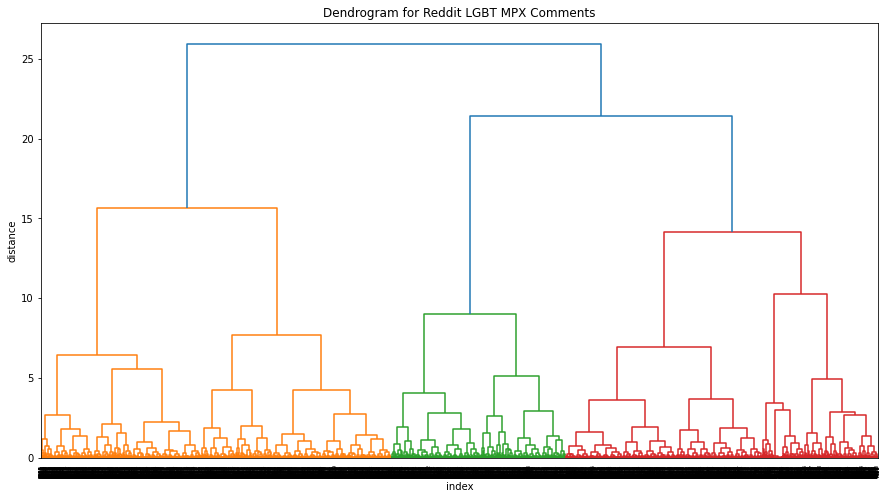

Time (in seconds) to visualize agglomerative clustering data via dendrogram: 204.46191420800096


In [42]:
start = timeit.default_timer()

model = shc.linkage( psych_data_principal, method ='ward' )
plt.figure(figsize =(15, 8))
plt.title('Dendrogram for Reddit LGBT MPX Comments')
plt.xlabel( 'index' )
plt.ylabel( 'distance' )
shc.dendrogram( model, leaf_rotation=90. )
plt.show()

stop = timeit.default_timer()
print( "Time (in seconds) to visualize agglomerative clustering data via dendrogram:", stop - start )

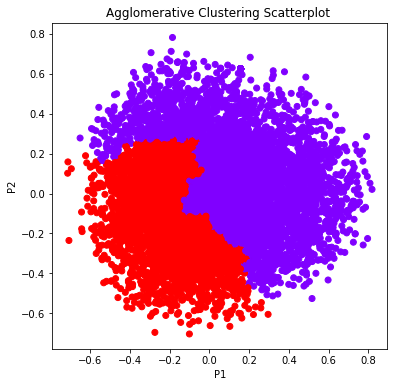

Time (in seconds) to visualize agglomerative clustering data via scatterplot: 3.3875042899999244


In [23]:
start = timeit.default_timer()

ac2 = AgglomerativeClustering(n_clusters = 2)
 
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(psych_data_principal['P1'], psych_data_principal['P2'],
           c = ac2.fit_predict(psych_data_principal), cmap ='rainbow')
plt.xlabel( 'P1' )
plt.ylabel( 'P2' )
plt.title( 'Agglomerative Clustering Scatterplot ')
plt.show()

stop = timeit.default_timer()
print( "Time (in seconds) to visualize agglomerative clustering data via scatterplot:", stop - start )

KMeans Cluster Analysis

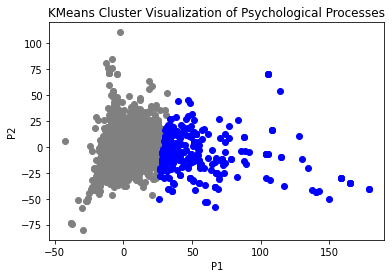

Time (in seconds) to visualize kmeans clustering data via scatterplot: 1.902958034999756


In [24]:
start = timeit.default_timer()

pca = PCA(2)
 
#Transform the data
data = pca.fit_transform( psych_data )

# Run kmeans cluster analysis
kmeans = KMeans( n_clusters = best_k ).fit( data )
label = kmeans.fit_predict ( data )

#filter rows of original data
filtered_label0 = data[label == 0]
filtered_label1 = data[label == 1]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color = 'gray' )
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color = 'blue' )
plt.xlabel( 'P1' )
plt.ylabel( 'P2' )
plt.title( 'KMeans Cluster Visualization of Psychological Processes' )
plt.show()

stop = timeit.default_timer()
print( "Time (in seconds) to visualize kmeans clustering data via scatterplot:", stop - start )

In [25]:
# Create a k-means clustering model
# Fit the data to the model
kmeans = KMeans( n_clusters = best_k ).fit( psych_data )

# Add cluster number to the original data
psych_data_clustered = pd.DataFrame(psych_data, columns=psych_data.columns, index=psych_data.index)
psych_data_clustered['cluster'] = label

psych_data_clustered.head()

,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,cluster
author,,,,,,,,,,,,,,,,,,,,,
clueless_claremont_,0.00,0.00,0.00,0.0,0.00,0.0,6.67,0.0,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0
Lizardd06,0.00,0.00,0.00,0.0,0.00,0.0,15.79,0.0,5.26,0.0,...,0.0,2.63,0.0,2.63,0.00,2.63,0.0,0.0,0.0,0
AnseaCirin,9.09,4.55,0.00,0.0,0.00,0.0,9.09,0.0,0.00,0.0,...,0.0,4.55,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0
Pirascule,4.44,0.00,4.44,0.0,2.22,0.0,13.33,0.0,0.00,0.0,...,0.0,2.22,0.0,2.22,2.22,0.00,0.0,0.0,0.0,0
JLH4AC,0.00,0.00,0.00,0.0,0.00,0.0,17.74,0.0,0.00,0.0,...,0.0,3.23,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0


In [26]:
# Normalize the data
# Normalize data from all columns except classification
x = psych_data_clustered.iloc[ :, 0:( len( psych_data.columns ) - 1 ) ]
psych_data_clustered.iloc[ :, 0:( len( psych_data.columns ) - 1 ) ] = ( x-x.min() )/ ( x.max() - x.min() )

psych_data_clustered.head()

,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,cluster
author,,,,,,,,,,,,,,,,,,,,,
clueless_claremont_,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0667,0.0,0.0000,0.0,...,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
Lizardd06,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.1579,0.0,0.1052,0.0,...,0.0,0.0263,0.0,0.0263,0.0000,0.0263,0.0,0.0,0.0,0
AnseaCirin,0.0909,0.0455,0.0000,0.0,0.0000,0.0,0.0909,0.0,0.0000,0.0,...,0.0,0.0455,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
Pirascule,0.0444,0.0000,0.0444,0.0,0.0222,0.0,0.1333,0.0,0.0000,0.0,...,0.0,0.0222,0.0,0.0222,0.0222,0.0000,0.0,0.0,0.0,0
JLH4AC,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.1774,0.0,0.0000,0.0,...,0.0,0.0323,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0


In [32]:
# Psychological foci
psych_data_clustered_pt1 = pd.DataFrame( {'Cognitive': psych_data_clustered['cogproc'], 
                                          'Social': psych_data_clustered['social'],
                                          'Perceptual': psych_data_clustered['percept'], 
                                          'Biological': psych_data_clustered['bio'],
                                          'Drives': psych_data_clustered['drives'],
                                          'Cluster': psych_data_clustered['cluster']})

# Cognitive
psych_data_clustered_pt2 = pd.DataFrame( {'Insight': psych_data_clustered['insight'], 
                                          'Cause': psych_data_clustered['cause'],
                                          'Discrepancy': psych_data_clustered['discrep'], 
                                          'Tentative': psych_data_clustered['tentat'],
                                          'Certainty': psych_data_clustered['certain'],
                                          'Differentiation': psych_data_clustered['differ'],
                                          'Cluster': psych_data_clustered['cluster']})

# Social
psych_data_clustered_pt3 = pd.DataFrame( {'Family': psych_data_clustered['family'], 
                                          'Friends': psych_data_clustered['friend'],
                                          'Female': psych_data_clustered['female'], 
                                          'Male': psych_data_clustered['male'],
                                          'Cluster': psych_data_clustered['cluster'] })                                                

# Drives
psych_data_clustered_pt4 = pd.DataFrame( {'Affiliation': psych_data_clustered['affiliation'], 
                                          'Achieve': psych_data_clustered['achieve'],
                                          'Power': psych_data_clustered['power'], 
                                          'Reward': psych_data_clustered['reward'],
                                          'Risk': psych_data_clustered['risk'],
                                          'Cluster': psych_data_clustered['cluster'] })

# Biological
psych_data_clustered_pt5 = pd.DataFrame( {'Body': psych_data_clustered['body...65'], 
                                          'Health': psych_data_clustered['health'],
                                          'Sexual': psych_data_clustered['sexual'], 
                                          'Ingest': psych_data_clustered['ingest'],
                                          'Cluster': psych_data_clustered['cluster'] })

# Perceptual
psych_data_clustered_pt6 = pd.DataFrame( {'See': psych_data_clustered['see'], 
                                          'Hear': psych_data_clustered['hear'],
                                          'Feel': psych_data_clustered['feel'],
                                          'Cluster': psych_data_clustered['cluster'] })                                                

# Informal Language
psych_data_clustered_pt7 = pd.DataFrame( {'Swear': psych_data_clustered['swear'], 
                                          'Netspeak': psych_data_clustered['netspeak'],
                                          'Assent': psych_data_clustered['assent'],
                                          'Nonfluencies': psych_data_clustered['nonflu'],
                                          'Fillers': psych_data_clustered['filler'],
                                          'Cluster': psych_data_clustered['cluster'] }) 

# Personal Concerns
psych_data_clustered_pt8 = pd.DataFrame( {'Work': psych_data_clustered['work'], 
                                          'Leisure': psych_data_clustered['leisure'],
                                          'Home': psych_data_clustered['home'],
                                          'Money': psych_data_clustered['money'],
                                          'Religion': psych_data_clustered['relig'],
                                          'Death': psych_data_clustered['death'],
                                          'Cluster': psych_data_clustered['cluster'] }) 

# Affective
psych_data_clustered_pt9 = pd.DataFrame( {'Affective': psych_data_clustered['affect'], 
                                          'Positive': psych_data_clustered['posemo'],
                                          'Negative': psych_data_clustered['negemo'],
                                          'Anxiety': psych_data_clustered['anx'],
                                          'Anger': psych_data_clustered['anger'],
                                          'Sadness': psych_data_clustered['sad'],
                                          'Cluster': psych_data_clustered['cluster'] })

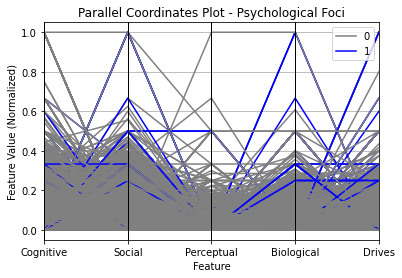

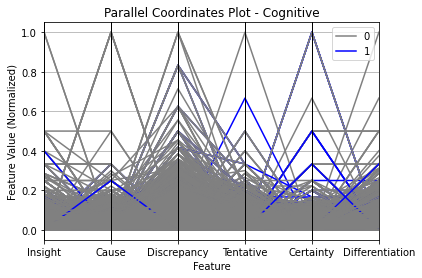

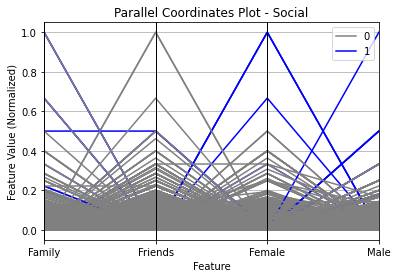

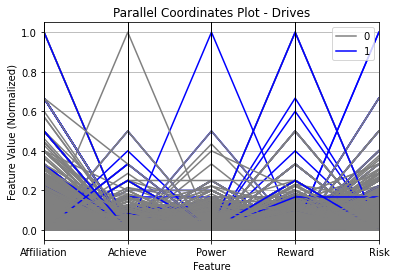

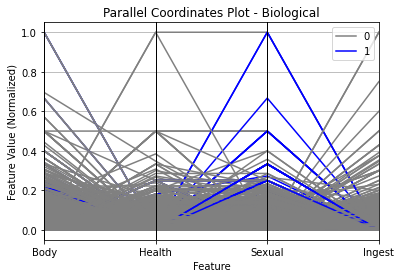

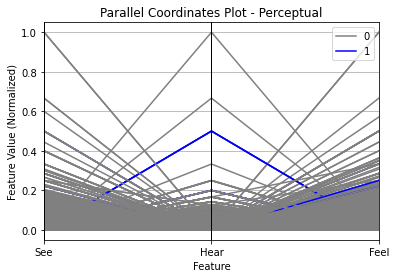

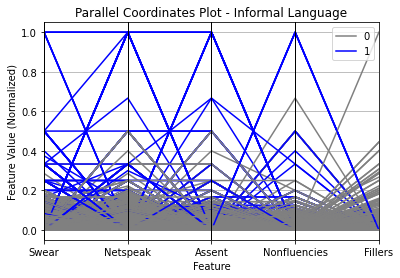

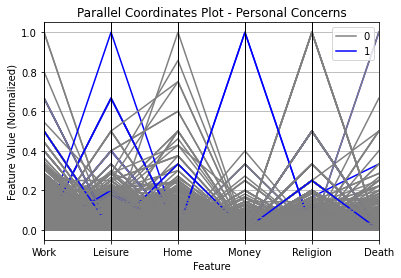

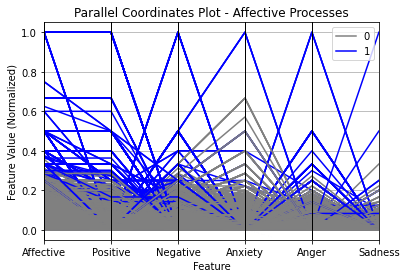

Time (in seconds) to visualize parallel coordinates plots: 135.87739101100124


In [34]:
start = timeit.default_timer()

pd.plotting.parallel_coordinates( psych_data_clustered_pt1, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Psychological Foci" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt2, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Cognitive" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt3, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Social" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt4, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Drives" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt5, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Biological" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt6, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Perceptual" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt7, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Informal Language" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt8, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Personal Concerns" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt9, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Affective Processes" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Normalized)")
plt.show()

stop = timeit.default_timer()
print( "Time (in seconds) to visualize parallel coordinates plots:", stop - start )

Try plotting parallel coordinates using standardization instead of normalization

In [35]:
# Standardize the data
scaler = StandardScaler()
psych_data_scaled = scaler.fit_transform(psych_data)
psych_data_scaled

# Create a k-means clustering model
# Fit the data to the model
kmeans = KMeans( n_clusters = best_k ).fit( psych_data_scaled )
label = kmeans.fit_predict ( psych_data_scaled )

# Add cluster number to the original data
psych_data_scaled_clustered = pd.DataFrame(psych_data_scaled, columns=psych_data.columns, index=psych_data.index)
psych_data_scaled_clustered['cluster'] = label

psych_data_scaled_clustered.head()

,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,cluster
author,,,,,,,,,,,,,,,,,,,,,
clueless_claremont_,-0.647020,-0.421283,-0.490356,-0.268848,-0.268821,-0.165282,-0.368472,-0.107564,-0.315222,-0.111525,...,-0.133516,-0.326223,-0.132914,-0.365032,-0.222242,-0.218462,-0.149305,-0.115677,-0.083173,0
Lizardd06,-0.647020,-0.421283,-0.490356,-0.268848,-0.268821,-0.165282,0.665224,-0.107564,2.222912,-0.111525,...,-0.133516,0.236107,-0.132914,-0.064166,-0.222242,0.239978,-0.149305,-0.115677,-0.083173,0
AnseaCirin,0.273247,0.123848,-0.490356,-0.268848,-0.268821,-0.165282,-0.094180,-0.107564,-0.315222,-0.111525,...,-0.133516,0.646630,-0.132914,-0.365032,-0.222242,-0.218462,-0.149305,-0.115677,-0.083173,0
Pirascule,-0.197517,-0.421283,0.290010,-0.268848,0.330865,-0.165282,0.386398,-0.107564,-0.315222,-0.111525,...,-0.133516,0.148444,-0.132914,-0.111069,0.269334,-0.218462,-0.149305,-0.115677,-0.083173,0
JLH4AC,-0.647020,-0.421283,-0.490356,-0.268848,-0.268821,-0.165282,0.886244,-0.107564,-0.315222,-0.111525,...,-0.133516,0.364396,-0.132914,-0.365032,-0.222242,-0.218462,-0.149305,-0.115677,-0.083173,0


In [36]:
# Psychological foci
psych_data_clustered_pt1 = pd.DataFrame( {'Cognitive': psych_data_scaled_clustered['cogproc'], 
                                          'Social': psych_data_scaled_clustered['social'],
                                          'Perceptual': psych_data_scaled_clustered['percept'], 
                                          'Biological': psych_data_scaled_clustered['bio'],
                                          'Drives': psych_data_scaled_clustered['drives'],
                                          'Cluster': psych_data_scaled_clustered['cluster']})

# Cognitive
psych_data_clustered_pt2 = pd.DataFrame( {'Insight': psych_data_scaled_clustered['insight'], 
                                          'Cause': psych_data_scaled_clustered['cause'],
                                          'Discrepancy': psych_data_scaled_clustered['discrep'], 
                                          'Tentative': psych_data_scaled_clustered['tentat'],
                                          'Certainty': psych_data_scaled_clustered['certain'],
                                          'Differentiation': psych_data_scaled_clustered['differ'],
                                          'Cluster': psych_data_scaled_clustered['cluster']})

# Social
psych_data_clustered_pt3 = pd.DataFrame( {'Family': psych_data_scaled_clustered['family'], 
                                          'Friends': psych_data_scaled_clustered['friend'],
                                          'Female': psych_data_scaled_clustered['female'], 
                                          'Male': psych_data_scaled_clustered['male'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] })                                                

# Drives
psych_data_clustered_pt4 = pd.DataFrame( {'Affiliation': psych_data_scaled_clustered['affiliation'], 
                                          'Achieve': psych_data_scaled_clustered['achieve'],
                                          'Power': psych_data_scaled_clustered['power'], 
                                          'Reward': psych_data_scaled_clustered['reward'],
                                          'Risk': psych_data_scaled_clustered['risk'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] })

# Biological
psych_data_clustered_pt5 = pd.DataFrame( {'Body': psych_data_scaled_clustered['body...65'], 
                                          'Health': psych_data_scaled_clustered['health'],
                                          'Sexual': psych_data_scaled_clustered['sexual'], 
                                          'Ingest': psych_data_scaled_clustered['ingest'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] })

# Perceptual
psych_data_clustered_pt6 = pd.DataFrame( {'See': psych_data_scaled_clustered['see'], 
                                          'Hear': psych_data_scaled_clustered['hear'],
                                          'Feel': psych_data_scaled_clustered['feel'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] })                                                

# Informal Language
psych_data_clustered_pt7 = pd.DataFrame( {'Swear': psych_data_scaled_clustered['swear'], 
                                          'Netspeak': psych_data_scaled_clustered['netspeak'],
                                          'Assent': psych_data_scaled_clustered['assent'],
                                          'Nonfluencies': psych_data_scaled_clustered['nonflu'],
                                          'Fillers': psych_data_scaled_clustered['filler'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] }) 

# Personal Concerns
psych_data_clustered_pt8 = pd.DataFrame( {'Work': psych_data_scaled_clustered['work'], 
                                          'Leisure': psych_data_scaled_clustered['leisure'],
                                          'Home': psych_data_scaled_clustered['home'],
                                          'Money': psych_data_scaled_clustered['money'],
                                          'Religion': psych_data_scaled_clustered['relig'],
                                          'Death': psych_data_scaled_clustered['death'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] }) 

# Affective
psych_data_clustered_pt9 = pd.DataFrame( {'Affective': psych_data_scaled_clustered['affect'], 
                                          'Positive': psych_data_scaled_clustered['posemo'],
                                          'Negative': psych_data_scaled_clustered['negemo'],
                                          'Anxiety': psych_data_scaled_clustered['anx'],
                                          'Anger': psych_data_scaled_clustered['anger'],
                                          'Sadness': psych_data_scaled_clustered['sad'],
                                          'Cluster': psych_data_scaled_clustered['cluster'] })

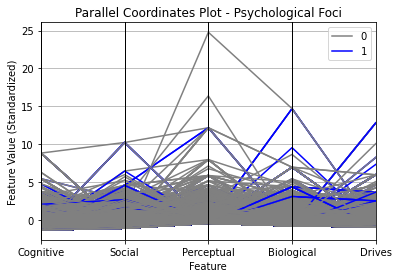

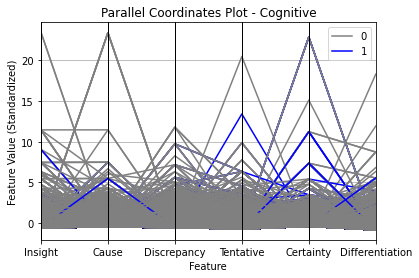

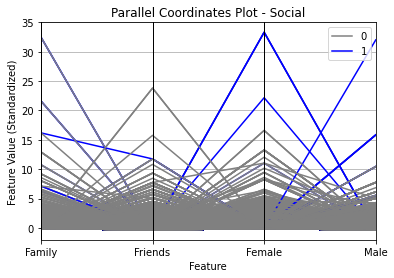

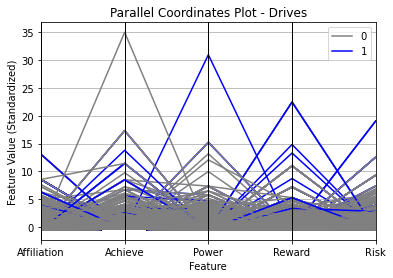

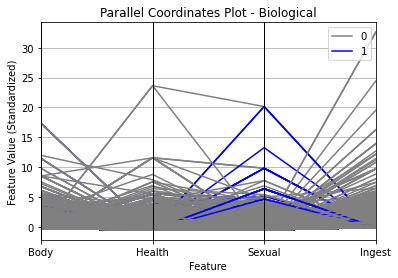

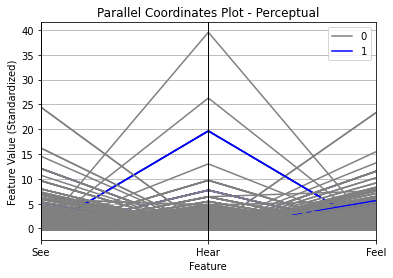

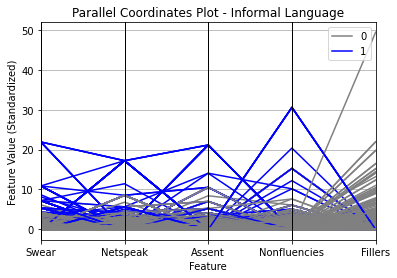

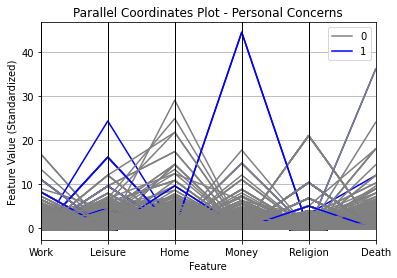

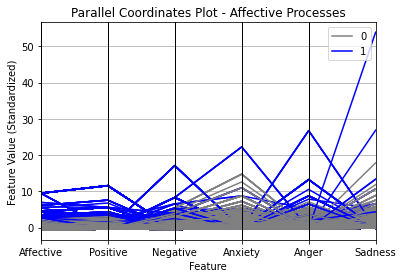

Time (in seconds) to visualize parallel coordinates plots (standardized): 129.2628674360003


In [37]:
start = timeit.default_timer()

pd.plotting.parallel_coordinates( psych_data_clustered_pt1, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Psychological Foci" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt2, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Cognitive" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt3, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Social" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt4, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Drives" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt5, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Biological" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt6, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Perceptual" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt7, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Informal Language" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt8, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Personal Concerns" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

pd.plotting.parallel_coordinates( psych_data_clustered_pt9, 'Cluster', color=('grey', 'blue') )
plt.title( "Parallel Coordinates Plot - Affective Processes" )
plt.xlabel( "Feature" )
plt.ylabel( "Feature Value (Standardized)")
plt.show()

stop = timeit.default_timer()
print( "Time (in seconds) to visualize parallel coordinates plots (standardized):", stop - start )